In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import anndata as ad
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull, Delaunay
from scipy.stats import mannwhitneyu
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from statsmodels.stats.multitest import multipletests
import sys
from scipy.stats import fisher_exact
from tqdm import tqdm 
sys.path.append("../src")
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
from border_effects_kNN_del import sample_points_on_square, trunc_graphs
from plotting import add_sig_bar

In [4]:
np.random.seed(41)

In [5]:
ks = [5, 10, 15]
Ns = [100, 1000, 10000]


mwu = dict()
fisher = dict()
mwu_adj = dict()
fisher_adj = dict()
new_edges = dict()

for N in Ns:
    mwu[N] = dict()
    fisher[N] = dict()
    mwu_adj[N] = dict()
    fisher_adj[N] = dict()
    new_edges[N] = dict()
    
    for k in ks:
        mwu[N][k] = list()
        fisher[N][k] = list()
        mwu_adj[N][k] = list()
        fisher_adj[N][k] = list()
        new_edges[N][k] = list()

        i = 0
        while(i < 1000):
            rand_coords = sample_points_on_square(N, 1, 1)
            try:
                out = trunc_graphs(coords=rand_coords, return_graphs=False, method="kNN", xlim=0.5, ylim=0.5, k=k)
                edge_df = out["edge_df"]
                old = edge_df.loc[~edge_df["New edge"], "Edge length"]
                new = edge_df.loc[edge_df["New edge"], "Edge length"]
                p_mwu_rand = mannwhitneyu(
                    old,
                    new,
                    alternative="two-sided"
                ).pvalue
        
                contingency = pd.crosstab(edge_df["New edge"], edge_df["Symmetry"])
                values = np.array([[contingency.loc[True, False], contingency.loc[True, True]],
                                          [contingency.loc[False, False], contingency.loc[False, True]]])
                _, p_fisher_rand = fisher_exact(values, alternative="greater")
                
            except:
                continue
            new_edges[N][k].append(len(new) / (len(new) + len(old)))
            mwu[N][k].append(p_mwu_rand)
            fisher[N][k].append(p_fisher_rand)
            i += 1
        _, fisher_adj[N][k], _, _ = multipletests(fisher[N][k], alpha=0.05, method="fdr_bh")
        _, mwu_adj[N][k], _, _ = multipletests(mwu[N][k], alpha=0.05, method="fdr_bh")

In [6]:
coords = sample_points_on_square(500, 1, 1)
out = trunc_graphs(coords=coords, return_graphs=True, method="kNN", xlim=0.5, ylim=0.5, k=5)

coords = out["coords"]
subset = out["subset"]

G = out["G"]
subG = out["subG"]
plotG = out["plotG"]
truncG = out["truncG"]

edge_df = out["edge_df"]

In [7]:
edge_df = out["edge_df"]
old = edge_df.loc[~edge_df["New edge"], "Edge length"]
new = edge_df.loc[edge_df["New edge"], "Edge length"]
p_mwu = mannwhitneyu(
    old,
    new,
    alternative="two-sided"
).pvalue

In [8]:
p_mwu

2.0772169105607992e-23

In [9]:
contingency = pd.crosstab(edge_df["New edge"], edge_df["Symmetry"])
values = np.array([[contingency.loc[True, False], contingency.loc[True, True]],
                          [contingency.loc[False, False], contingency.loc[False, True]]])
_, p = fisher_exact(values, alternative="greater")
print(p)

1.1462092372399633e-24


In [10]:
contingency

Symmetry,False,True
New edge,,
False,91,512
True,38,4


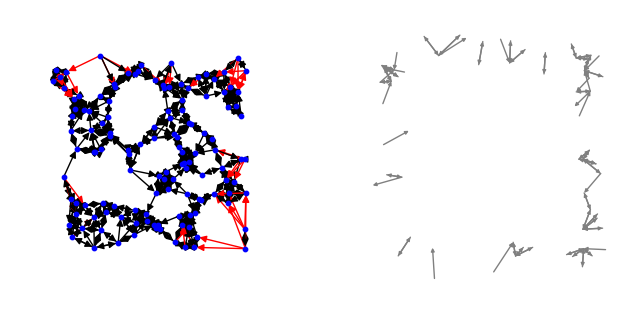

In [11]:
f, axs = plt.subplots(1, 2, figsize=(8, 4))
arrowsize=10
edge_colors = [edge in G.edges for edge in truncG.edges]
nx.draw(truncG, node_size=10, pos=coords, ax=axs[0], node_color="blue", edge_color=np.where(edge_colors, "black", "red"), arrowsize=arrowsize) #, node_color=subcoords[:, 2], cmap="magma", vmin=-1, vmax=1)

plotG.remove_edges_from(subG.edges)
plotG.remove_edges_from(truncG.edges)
nx.draw(plotG, node_size=0, pos=coords, ax=axs[1], edge_color="gray", arrowsize=5)

for ax in axs:
    ax.set_aspect('equal')
axs[0].set_xlim(axs[1].get_xlim())
axs[0].set_ylim(axs[1].get_ylim())
plt.savefig("../result_plots/fig2/kNN_trunc_1.svg")

In [12]:
dfs = dict()
for n in mwu_adj:
    dfs[n] = pd.DataFrame(mwu_adj[n])
conc = pd.concat(dfs).reset_index().rename({"level_0": "N"}, axis=1).drop("level_1", axis=1)
lengths = pd.melt(conc, var_name="k", id_vars="N")
lengths.loc[:, "value"] = np.log10(lengths.loc[:, "value"])
lengths.loc[:, "value"] = np.where(lengths.loc[:, "value"] < -100, -100, lengths.loc[:, "value"])

/data/bionets/je30bery/conda/envs/trunc/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [13]:
dfs = dict()
for n in fisher_adj:
    dfs[n] = pd.DataFrame(fisher_adj[n])
conc = pd.concat(dfs).reset_index().rename({"level_0": "N"}, axis=1).drop("level_1", axis=1)
syms = pd.melt(conc, var_name="k", id_vars="N")
syms.loc[:, "value"] = np.log10(syms.loc[:, "value"])
syms.loc[:, "value"] = np.where(syms.loc[:, "value"] < -100, -100, syms.loc[:, "value"])

/data/bionets/je30bery/conda/envs/trunc/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
dfs = dict()
for n in new_edges:
    dfs[n] = pd.DataFrame(new_edges[n])
conc = pd.concat(dfs).reset_index().rename({"level_0": "N"}, axis=1).drop("level_1", axis=1)
perc = pd.melt(conc, var_name="k", id_vars="N")
perc.loc[:, "value"] = perc.loc[:, "value"] * 100

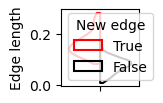

In [15]:
f, ax = plt.subplots(1, 1, figsize=(1, 1))
sns.violinplot(edge_df, y="Edge length", hue="New edge", cut=0, fill=False, split=True, palette={False: "black", True: "red"}, ax=ax, hue_order=[True, False], inner=None)
plt.savefig("../result_plots/fig2/kNN_trunc_2.svg")

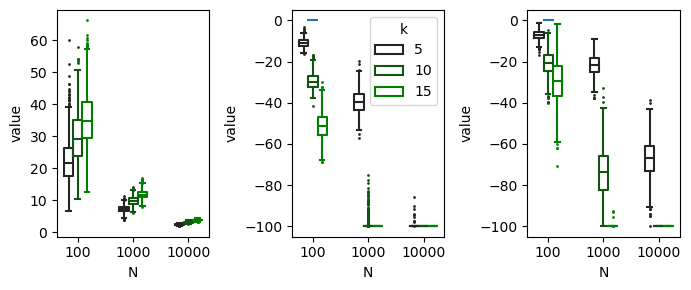

In [16]:
f, axs = plt.subplots(1, 3, figsize=(7, 3), sharex=True)
sns.boxplot(perc, x="N", y="value", hue="k", palette="dark:green", ax=axs[0],fliersize=1, fill=False, legend=False, width=0.5)

sns.boxplot(lengths, x="N", y="value", hue="k", ax=axs[1], palette="dark:green", fliersize=1, fill=False, width=0.5)
axs[1].hlines(0.001, xmin=-0.1, xmax=0.1)

sns.boxplot(syms, x="N", y="value", hue="k", ax=axs[2], palette="dark:green", fliersize=1, fill=False, legend=False, width=0.5)
axs[2].hlines(0.001, xmin=-0.1, xmax=0.1)
plt.tight_layout()
plt.savefig("../result_plots/fig2/kNN_trunc_3.svg")

In [17]:
print(np.sum(lengths[lengths["N"] == 100]["value"] < np.log10(0.05)))
print(np.sum(lengths[lengths["N"] == 100]["value"] < np.log10(0.01)))
print(np.sum(lengths[lengths["N"] == 100]["value"] < np.log10(0.001)))

3000
3000
3000


In [18]:
print(np.sum(lengths[lengths["N"] == 1000]["value"] < np.log10(0.05)))
print(np.sum(lengths[lengths["N"] == 1000]["value"] < np.log10(0.01)))
print(np.sum(lengths[lengths["N"] == 1000]["value"] < np.log10(0.001)))

3000
3000
3000


In [19]:
print(np.sum(lengths[lengths["N"] == 10000]["value"] < np.log10(0.05)))
print(np.sum(lengths[lengths["N"] == 10000]["value"] < np.log10(0.01)))
print(np.sum(lengths[lengths["N"] == 10000]["value"] < np.log10(0.001)))

3000
3000
3000


In [20]:
print(perc[(perc["N"] == 100) & (perc["k"] == 5)].median())
print(perc[(perc["N"] == 100) & (perc["k"] == 10)].median())
print(perc[(perc["N"] == 100) & (perc["k"] == 15)].median())

N            100.0
k              5.0
value    21.702899
dtype: object
N            100.0
k             10.0
value    29.166667
dtype: object
N            100.0
k             15.0
value    34.761905
dtype: object


In [21]:
print(perc[(perc["N"] == 1000) & (perc["k"] == 5)].median())
print(perc[(perc["N"] == 1000) & (perc["k"] == 10)].median())
print(perc[(perc["N"] == 1000) & (perc["k"] == 15)].median())

N          1000.0
k             5.0
value    7.102041
dtype: object
N          1000.0
k            10.0
value    9.660377
dtype: object
N           1000.0
k             15.0
value    11.739135
dtype: object


In [22]:
print(perc[(perc["N"] == 10000) & (perc["k"] == 5)].median())
print(perc[(perc["N"] == 10000) & (perc["k"] == 10)].median())
print(perc[(perc["N"] == 10000) & (perc["k"] == 15)].median())

N         10000.0
k             5.0
value    2.289132
dtype: object
N         10000.0
k            10.0
value    3.109744
dtype: object
N         10000.0
k            15.0
value    3.762585
dtype: object


In [26]:
for N, sub_df in syms.groupby("N"):
    for k, sub_sub_df in sub_df.groupby("k"):
        p1 = np.sum(syms[(syms["N"] == N) & (syms["k"] == k)]["value"] < np.log10(0.05))
        p2 = np.sum(syms[(syms["N"] == N) & (syms["k"] == k)]["value"] < np.log10(0.01))
        p3 = np.sum(syms[(syms["N"] == N) & (syms["k"] == k)]["value"] < np.log10(0.001))

        if p1 < 1000:
            print(N, k, 0.05, p1)
        if p2 < 1000:
            print(N, k, 0.01, p2)
        if p3 < 1000:
            print(N, k, 0.001, p3)

100 5 0.01 993
100 5 0.001 974
100 15 0.01 999
100 15 0.001 997
